# Neural-Fly: Domain Adversarially Invariant Meta Learning

This script loads quadrotor flight data in different wind conditions, trains a wind invariant representation of the unmodeled aerodynamics, and tests the performance of the model when adapting to new data in different wind conditions. 

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import utils
import mlmodel

In [2]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on linux, setting 2 workers


## Load the data and create some simple visualizations

In [3]:
dim_a = 4  # lxz:调节隐层的维度
features = ['v', 'q', 'pwm']
label = 'fa'

# Training data collected from the neural-fly drone
dataset = 'rflysim'  # 'neural-fly'
dataset_folder = 'data_csv/random/6'
hover_pwm_ratio = 1.

# # Training data collected from an intel aero drone
# dataset = 'neural-fly-transfer'
# dataset_folder = 'data/training-transfer'
# hover_pwm = 910 # mean hover pwm for neural-fly drone
# intel_hover_pwm = 1675 # mean hover pwm for intel-aero drone
# hover_pwm_ratio = hover_pwm / intel_hover_pwm # scaling ratio from system id

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

In [4]:
RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label)

testdata_folder = 'data_csv/figure8/1'
RawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')  # lxz:总共提取四次实验，不包含sin信号的变化风环境
# RawData = utils.load_data(testdata_folder, expnames='(NF_)([0-9]*|no)wind')  # lxz:总共提取四次实验，不包含sin信号的变化风环境
TestData = utils.format_data(RawData, features=features, output=label, hover_pwm_ratio=hover_pwm_ratio) # wind condition label, C, will not make sense for this data - that's okay since C is only used in the training process

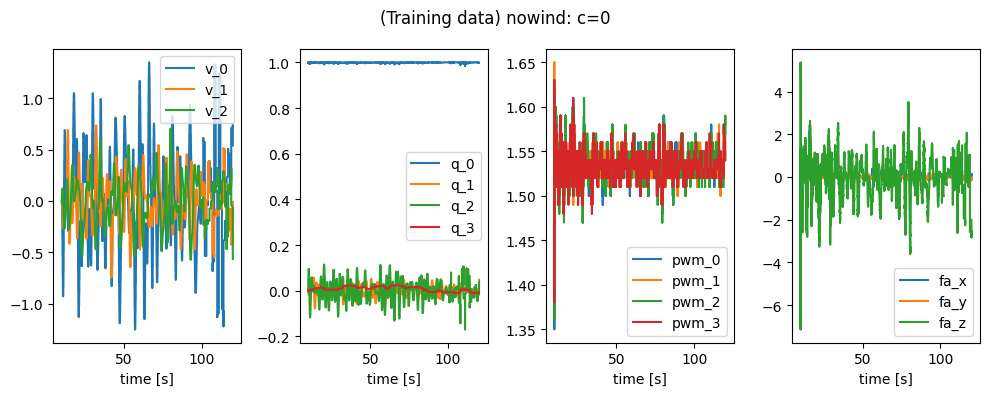

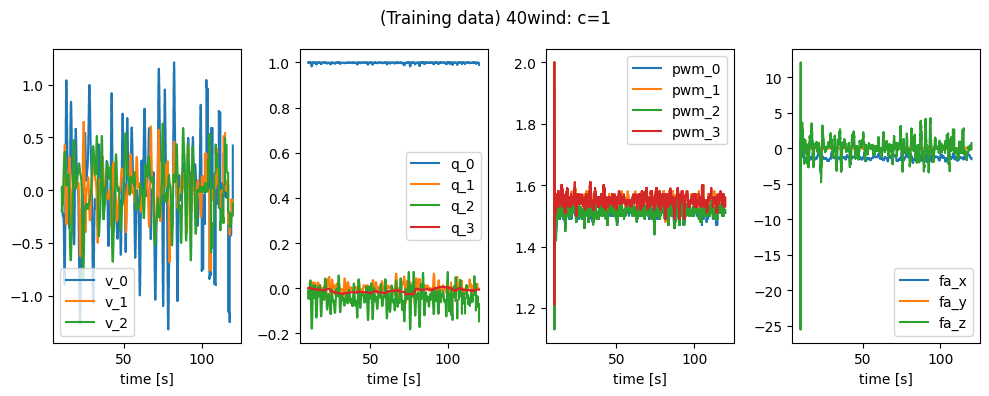

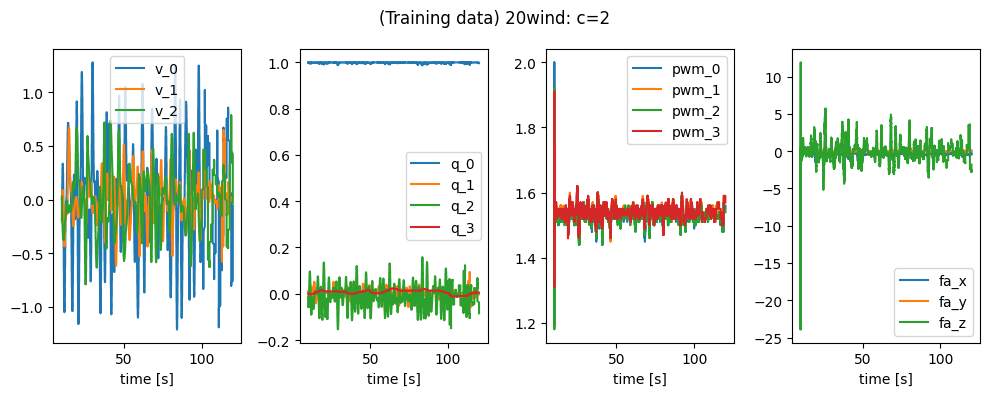

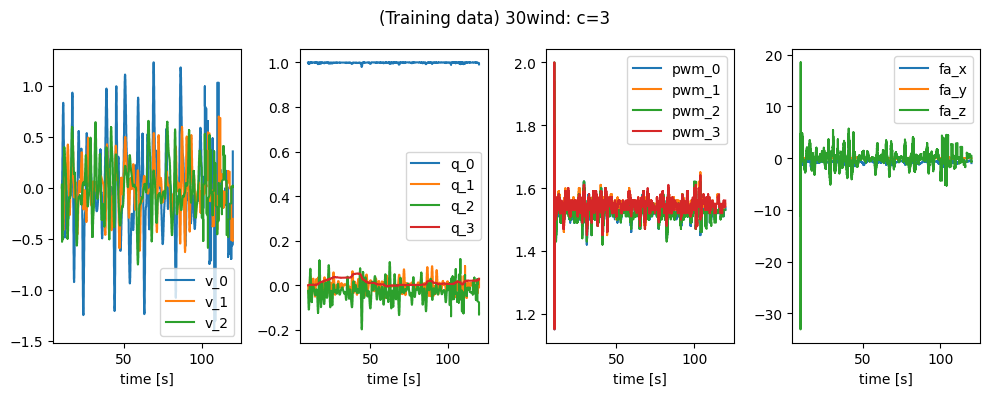

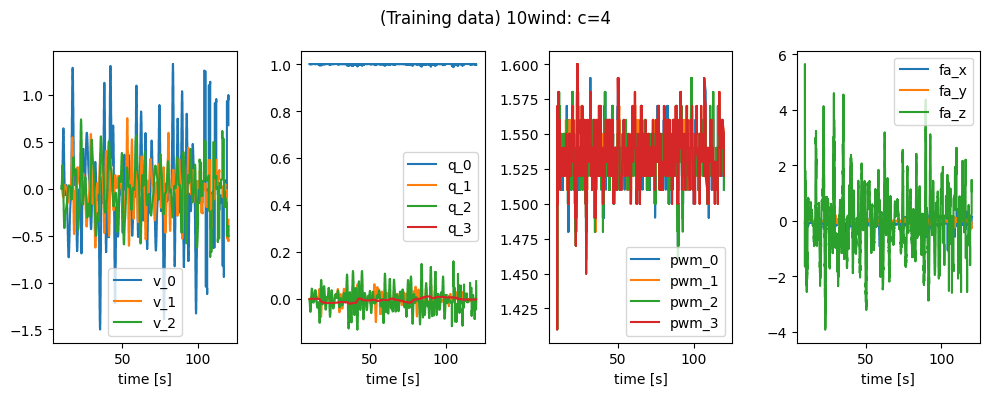

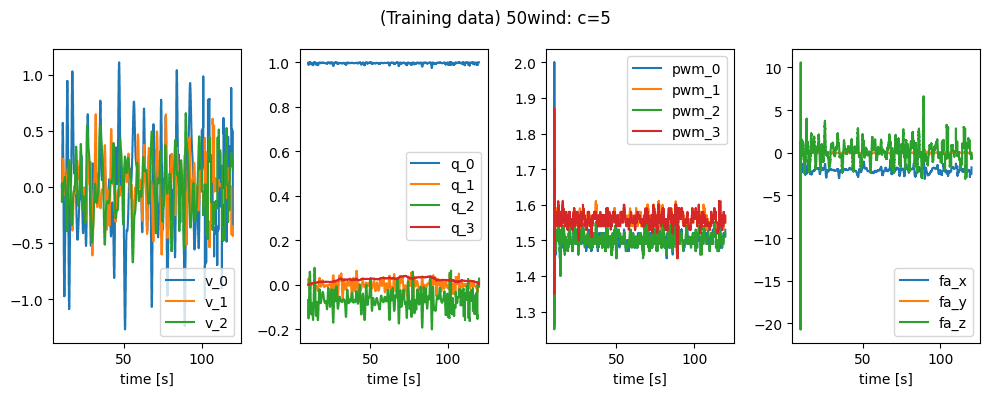

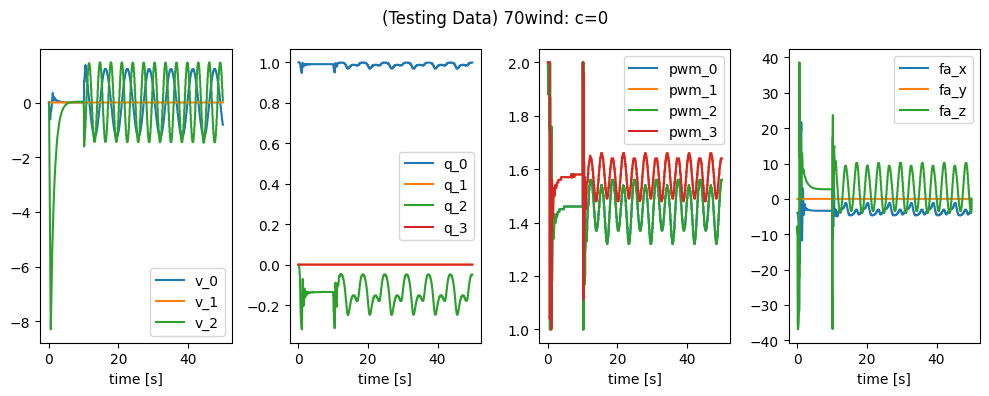

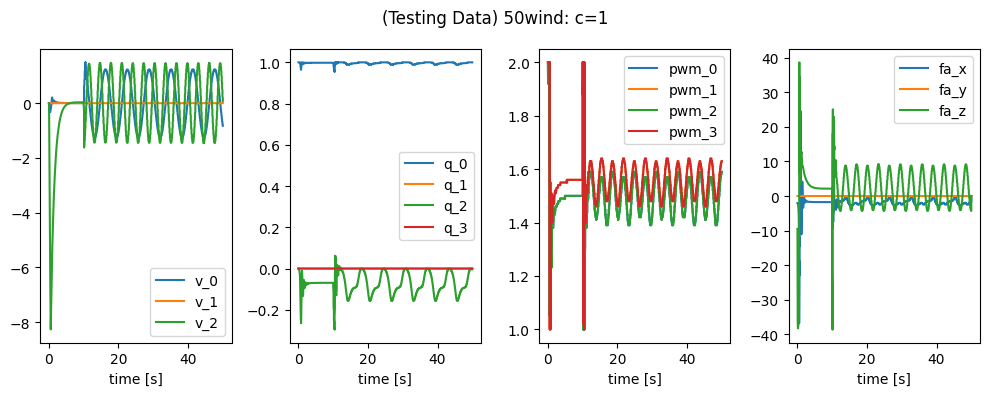

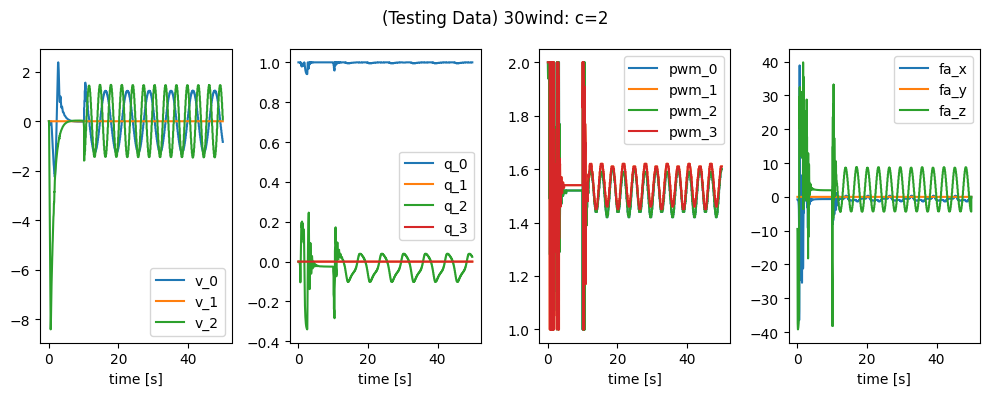

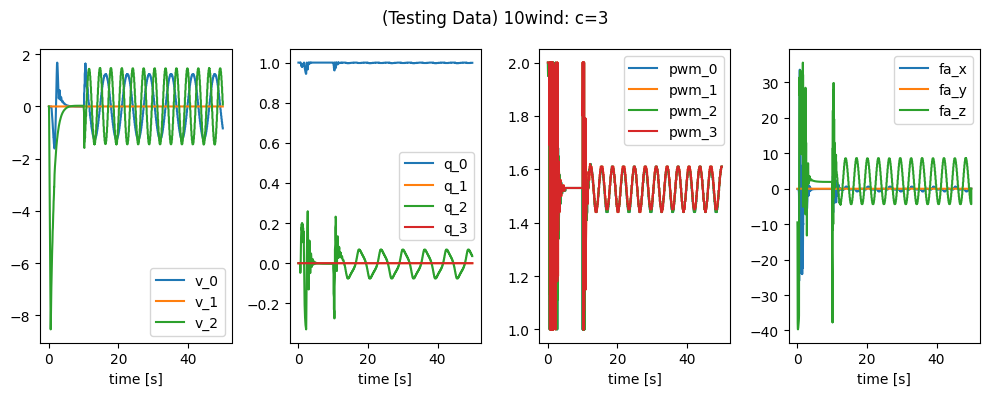

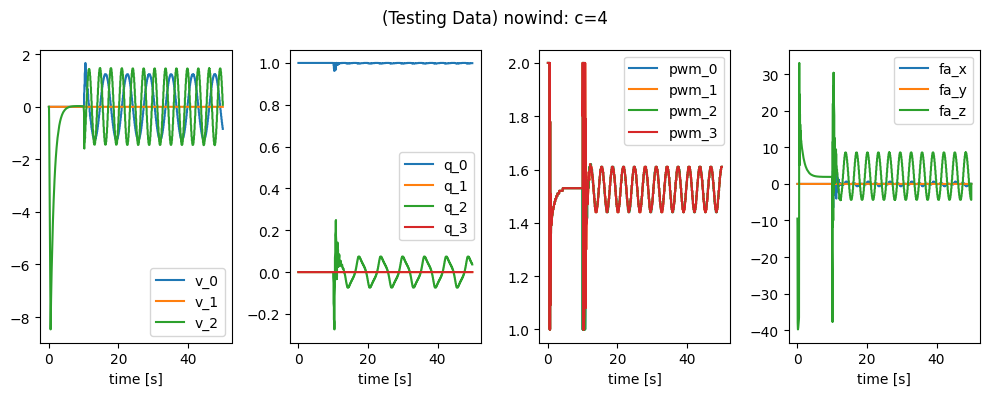

In [5]:
for data in Data:
    utils.plot_subdataset(data, features, title_prefix="(Training data)")

for data in TestData:
    utils.plot_subdataset(data, features, title_prefix="(Testing Data)")

## Initialize some other hyperparameters

In [6]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (11, 3)
there are 6 different conditions


In [7]:
# Set hyperparameters
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 500

# Dataset Generation

The adaptation dataset will be used to update $a$ in each training loop.
The training dataset will be used to train $\phi$ in each training loop.

In [8]:
# Trainset = []
# Adaptset = []
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i].X, Data[i].Y, Data[i].C)
    
    l = len(Data[i].X)
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i].X[:int(2/3*l)], Data[i].Y[:int(2/3*l)], Data[i].C)  # lxz: 占整个dataset的2/3
        adaptset = mlmodel.MyDataset(Data[i].X[int(2/3*l):], Data[i].Y[int(2/3*l):], Data[i].C)  # lxz: 占整个dataset的1/3，与trainset不相交

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

# Domain Adversarially Invariant Meta Learning

Assume the state $x\in\mathbb{R}^n$ and $c$ is hidden state used to represent changing environment. We are interested in learning some function $f(x(t),c(t))$. $f(x(t),c(t))$ can be separated into three terms: $$f(x(t),c(t))=\phi(x(t))a(c(t))+d(t),$$
where $\phi(x(t))$ captures the $c$-variant part and $a(c(t))\in\mathbb{R}^m$ is implicitly a function of the hidden state $c(t)$. Finally, $d(t)$ is the residual noise term.

We want to learn $\phi(x)$ such that it doesn't include any information about $c$. To reach this goal, we introduce another neural network $h$ where $h(\phi(x))$ tries to predict $c$.

The loss function is given as
$$\max_h\min_{\phi, \left\{a_{c_j}\right\}_j}\sum_{j}\sum_{i}\left\|\phi(x^{(i)}_{c_j})a_{c_j}-f(x^{(i)}_{c_j},c_j)\right\|^2-\alpha\cdot\text{CrossEntropy}\left(h(\phi(x^{(i)}_{c_j})),j\right)$$
Note that the $\text{CrossEntropy-loss}$ will not require physical encoding of $c_j$ in training, only a label for $c$ that corresponds to the subdataset (that is, the label $c$ has no physical meaning).

# Initialize the models

In [9]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.Phi_Net(options)
h_net = mlmodel.H_Net_CrossEntropy(options)

In [10]:
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])

# Meta-Training Algorithm

**Step 0: sample $c$, and sample $B+K$ data points in correponding subdataset $\{x_i,c,f(x_i,c)\}_{i}$**

**Step 1: estimate $a$ using least-square**

$K$ data points (sampled from the same wind condition $c$) are used to compute $a$ using least-squares, i.e., adaptation:
$$
\underbrace{
    \begin{bmatrix}
        \phi(x_1) \\ \phi(x_2) \\ \vdots \\ \phi(x_K) 
    \end{bmatrix}}
    _{\Phi\in\mathbb{R}^{K\times \dim(a)}}
\cdot
\underbrace{
    \begin{bmatrix}
        a_1 & \cdots & a_{\dim(y)} 
    \end{bmatrix}}
    _{a\in\mathbb{R}^{\dim(a)\times \dim(y)}}
=
\underbrace{
    \begin{bmatrix}
        f_1(x_1) & \cdots & f_{\dim(y)}(x_1) \\ f_1(x_2) & \cdots & f_{\dim(y)}(x_2) \\ \vdots & \vdots & \vdots\\ f_1(x_K) & \cdots & f_{\dim(y)}(x_K) 
    \end{bmatrix}}
    _{Y\in\mathbb{R}^{K\times \dim(y)}}
$$

The least square solution is given by
$$a=(\Phi^\top\Phi)^{-1}\Phi^\top Y$$
Normalization on $a$ is implemented to avoid ambiguity of $\phi(x)a$ (since $\phi(x)a=(0.1\phi(x))\cdot(10a)$):
$$a\leftarrow \gamma\cdot\frac{a}{\|a\|_F},\quad\text{if}\,\,\|a\|_F>\gamma$$
Note that $a$ is an implicit function of $\phi$.

**Step 2: fix $h$ and train $\phi$**

With this $a$, another $B$ data points (with same $c$) are used for gradient descent with loss
$$\mathcal{L}(\phi)=\|f(x)-\phi(x)a\|_2^2-\alpha\cdot\|h(\phi(x))-c\|_2^2$$

**Step 3: fix $\phi$ and train discriminator $h$**

Finally, these $B$ data points are used again for gradient descent on $h$ with loss
$$\mathcal{L}(h)=\|h(\phi(x))-c\|_2^2$$
We may run this step less frequently than step 2, to improve stability in training (a trick from GAN).

In [11]:
model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in range(options['num_epochs']):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
        
        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data['input'] # K x dim_x
        Y = kshot_data['output'] # K x dim_y
        Phi = phi_net(X) # K x dim_a
        Phi_T = Phi.transpose(0, 1) # dim_a x K
        A = torch.inverse(torch.mm(Phi_T, Phi)) # dim_a x dim_a
        a = torch.mm(torch.mm(A, Phi_T), Y) # dim_a x dim_y
        if torch.norm(a, 'fro') > options['gamma']:
            a = a / torch.norm(a, 'fro') * options['gamma']
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'] # B x dim_x
        labels = data['output'] # B x dim_y
        
        c_labels = data['c'].type(torch.long)
            
        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = criterion_h(h_net(temp), c_labels)
            
        loss_phi = loss_f - options['alpha'] * loss_c
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h']:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if options['SN'] > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > options['SN']:
                        param.data = param / s * options['SN']
         
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])
    Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))

        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics(TestData[j].X, TestData[j].Y, phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

[1] loss_f: 0.85 loss_c: 1.82
[11] loss_f: 0.65 loss_c: 1.82
[21] loss_f: 0.70 loss_c: 1.82
[31] loss_f: 0.67 loss_c: 1.81
[41] loss_f: 0.51 loss_c: 1.81
[51] loss_f: 0.55 loss_c: 1.81
[61] loss_f: 0.53 loss_c: 1.81
[71] loss_f: 0.58 loss_c: 1.81
[81] loss_f: 0.74 loss_c: 1.81
[91] loss_f: 0.50 loss_c: 1.81
[101] loss_f: 0.49 loss_c: 1.80
[111] loss_f: 0.56 loss_c: 1.80
[121] loss_f: 0.57 loss_c: 1.80
[131] loss_f: 0.61 loss_c: 1.80
[141] loss_f: 0.56 loss_c: 1.80
[151] loss_f: 0.56 loss_c: 1.80
[161] loss_f: 0.58 loss_c: 1.80
[171] loss_f: 0.54 loss_c: 1.80
[181] loss_f: 0.51 loss_c: 1.80
[191] loss_f: 0.52 loss_c: 1.80
[201] loss_f: 0.41 loss_c: 1.80


Traceback (most recent call last):
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-715123_a'


[211] loss_f: 0.41 loss_c: 1.80
[221] loss_f: 0.44 loss_c: 1.80
[231] loss_f: 0.42 loss_c: 1.80
[241] loss_f: 0.33 loss_c: 1.80
[251] loss_f: 0.27 loss_c: 1.80
[261] loss_f: 0.17 loss_c: 1.80
[271] loss_f: 0.11 loss_c: 1.80
[281] loss_f: 0.08 loss_c: 1.80
[291] loss_f: 0.08 loss_c: 1.80
[301] loss_f: 0.09 loss_c: 1.80
[311] loss_f: 0.06 loss_c: 1.80
[321] loss_f: 0.13 loss_c: 1.80
[331] loss_f: 0.06 loss_c: 1.80


Traceback (most recent call last):
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1gt62ton'


[341] loss_f: 0.10 loss_c: 1.79
[351] loss_f: 0.11 loss_c: 1.80
[361] loss_f: 0.05 loss_c: 1.80
[371] loss_f: 0.06 loss_c: 1.80
[381] loss_f: 0.05 loss_c: 1.80
[391] loss_f: 0.05 loss_c: 1.79
[401] loss_f: 0.05 loss_c: 1.79
[411] loss_f: 0.05 loss_c: 1.79
[421] loss_f: 0.04 loss_c: 1.79
[431] loss_f: 0.06 loss_c: 1.79
[441] loss_f: 0.06 loss_c: 1.80
[451] loss_f: 0.05 loss_c: 1.79


Traceback (most recent call last):
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/linxzh/anaconda3/envs/ml/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2gyq3_d7'


[461] loss_f: 0.06 loss_c: 1.79
[471] loss_f: 0.05 loss_c: 1.79
[481] loss_f: 0.04 loss_c: 1.80
[491] loss_f: 0.06 loss_c: 1.80


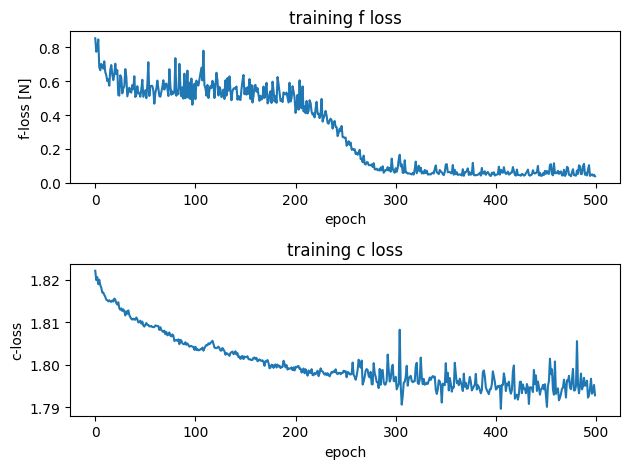

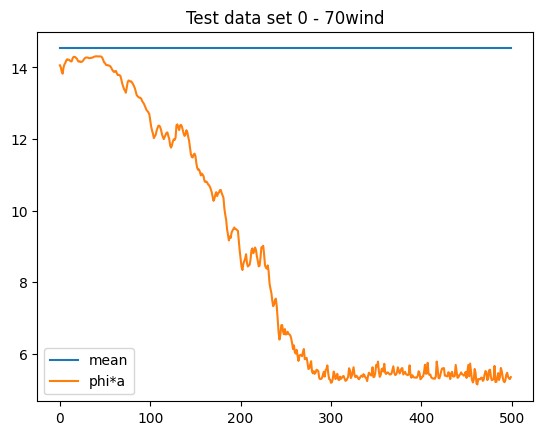

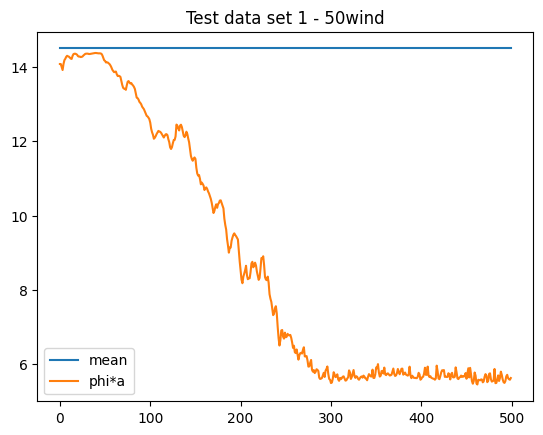

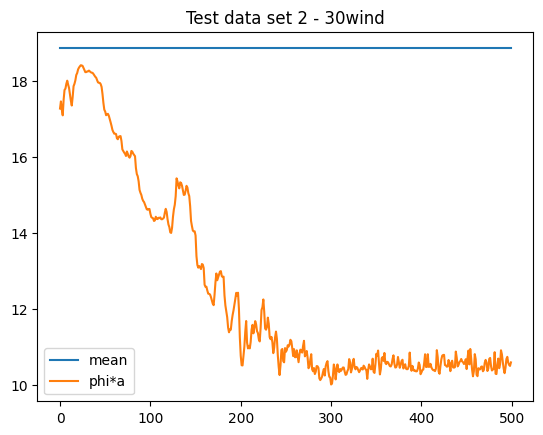

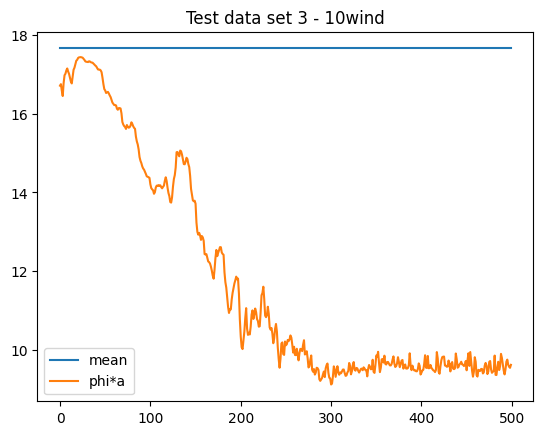

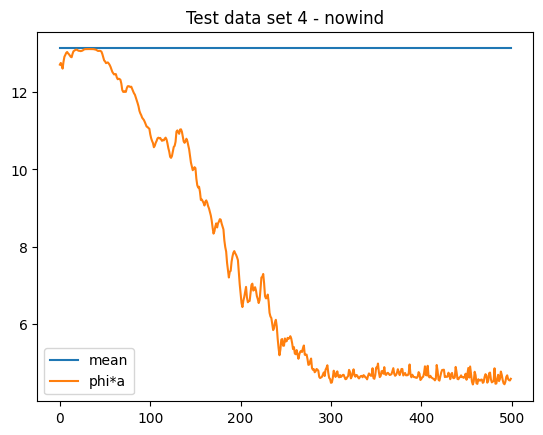

In [12]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()


# lxz:图的x轴是训练的次数，y轴是loss，表示随时间变化的训练过程中，不同风速环境下残差力预测的loss值
for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [13]:
# Choose final model
stopping_epoch = 450
options['num_epochs'] = stopping_epoch
final_model = mlmodel.load_model(modelname = modelname + '-epoch-' + str(stopping_epoch))

# Error Analysis

Plot the measured aerodynamic force, labeled ground truth (gt), along with the region used for adapation (adapt), and the predicted region (val)

------------------------------
nowind:
a = [[-0.23714936  0.37437462 -0.08305548]
 [-0.02000936 -0.06369443  5.64668518]
 [-0.22751718  0.11001616 -4.35260121]
 [ 0.06363741 -0.01728534  1.34124356]]
|a| = 7.273588731095864


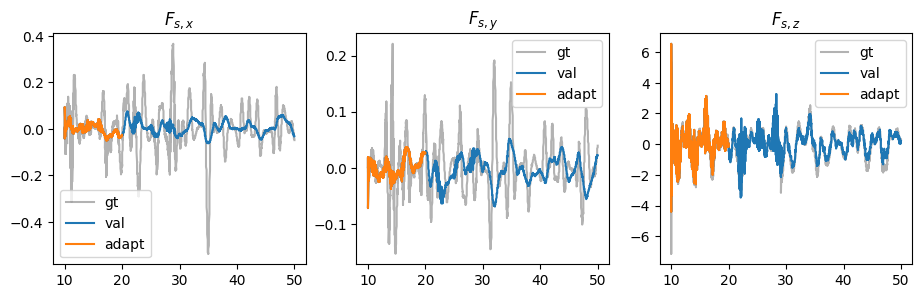

------------------------------
40wind:
a = [[-6.12820040e-01  2.34646399e-01  4.02472469e-01]
 [-1.27265911e+00  3.39711776e-03  6.59281299e+00]
 [-2.40584322e+00  1.42009721e-01 -4.76564592e+00]
 [-5.68955114e-01 -4.64604898e-02  1.49304114e+00]]
|a| = 8.760828556042544


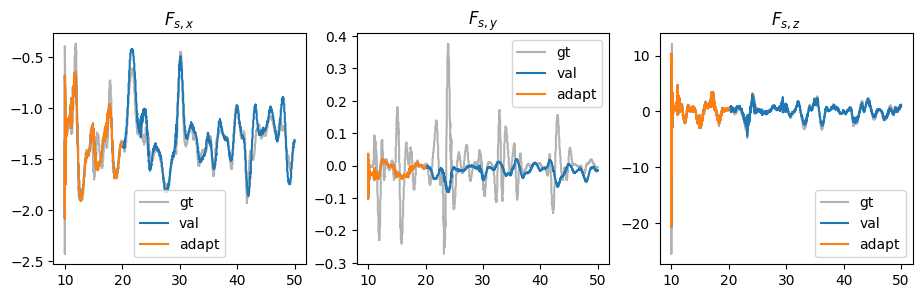

------------------------------
20wind:
a = [[-1.55683312 -0.05767862  1.14543323]
 [-0.41506489  0.01329786  5.46881471]
 [-1.30347045  0.02779041 -5.13536219]
 [-0.04808579 -0.01221421  1.66213824]]
|a| = 8.040919150367776


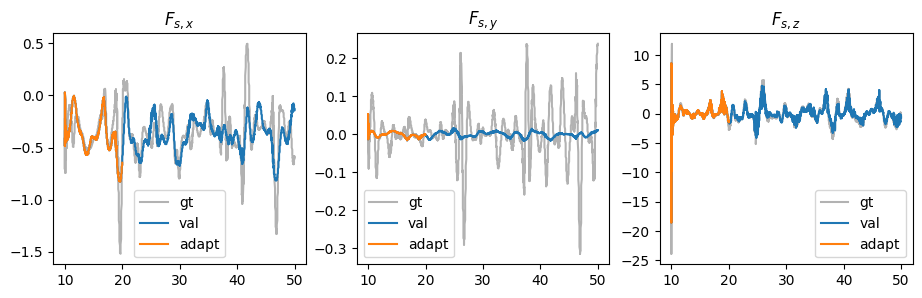

------------------------------
30wind:
a = [[ 0.12662456 -0.22640604  1.32687281]
 [-1.37131402 -0.12024348  7.23637733]
 [-2.26585076 -0.19779015 -5.28765122]
 [-0.04388245  0.04502641  1.69015324]]
|a| = 9.595886071926307


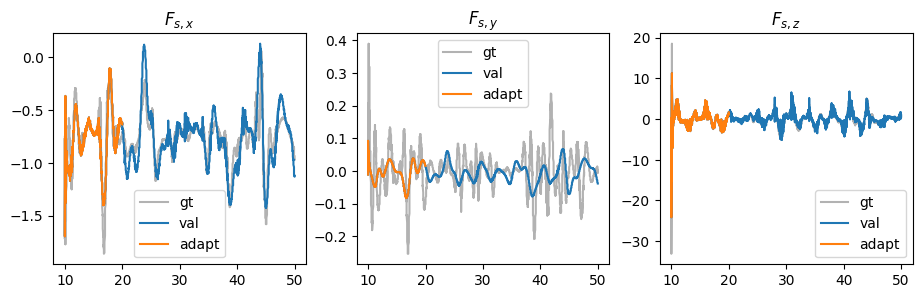

------------------------------
10wind:
a = [[ 0.18386132  0.27447474 -1.05329774]
 [-0.66737507 -0.10442894  7.09679373]
 [-0.4466359   0.09326431 -5.19058893]
 [ 0.0508124  -0.01009657  1.4567239 ]]
|a| = 9.01745403930839


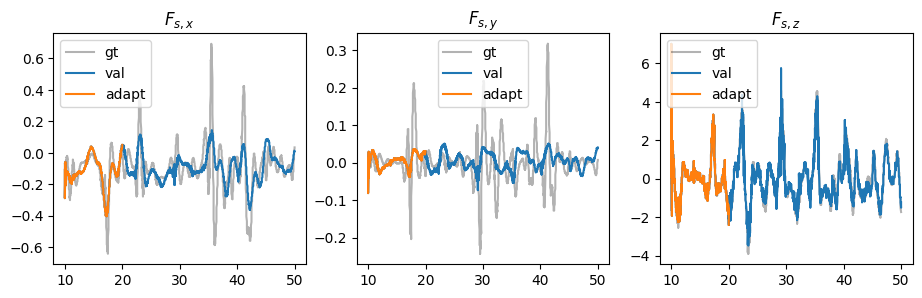

------------------------------
50wind:
a = [[-1.37595637  0.08280925 -1.05422389]
 [-1.03120461 -0.02114224  6.98299145]
 [-2.97873821 -0.04225701 -4.69284832]
 [-1.16081651  0.01661783  1.49497989]]
|a| = 9.34439560608235


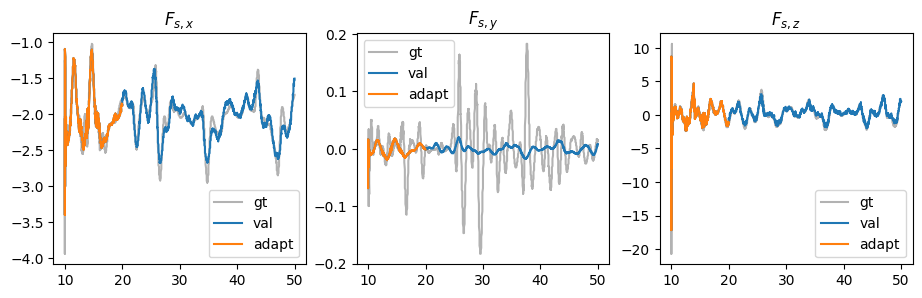

In [14]:
for i, data in enumerate(Data):  # lxz:使用测试数据进行测试
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=500, idx_val_start=0, idx_val_end=2000, c=Data[i].C, options=options)

In [15]:
for data in Data:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** c =', str(data.C), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : nowind ****
Before learning: MSE is  0.32
Mean predictor: MSE is  0.32
After learning phi(x): MSE is  0.03

**** c = 1 : 40wind ****
Before learning: MSE is  1.13
Mean predictor: MSE is  0.55
After learning phi(x): MSE is  0.04

**** c = 2 : 20wind ****
Before learning: MSE is  0.66
Mean predictor: MSE is  0.62
After learning phi(x): MSE is  0.05

**** c = 3 : 30wind ****
Before learning: MSE is  0.91
Mean predictor: MSE is  0.72
After learning phi(x): MSE is  0.09

**** c = 4 : 10wind ****
Before learning: MSE is  0.49
Mean predictor: MSE is  0.49
After learning phi(x): MSE is  0.03

**** c = 5 : 50wind ****
Before learning: MSE is  1.92
Mean predictor: MSE is  0.52
After learning phi(x): MSE is  0.04



## Test Data Error Analysis

------------------------------
70wind:
a = [[-2.44324261e+00  2.52949993e-18 -5.33213404e+00]
 [-1.37320836e+00  1.30702842e-17  8.41147874e+00]
 [-4.52085512e+00  1.48780517e-17 -8.71488187e+00]
 [-2.49297651e+00 -4.48518029e-18  3.87930362e+00]]
|a| = 14.989696101358694


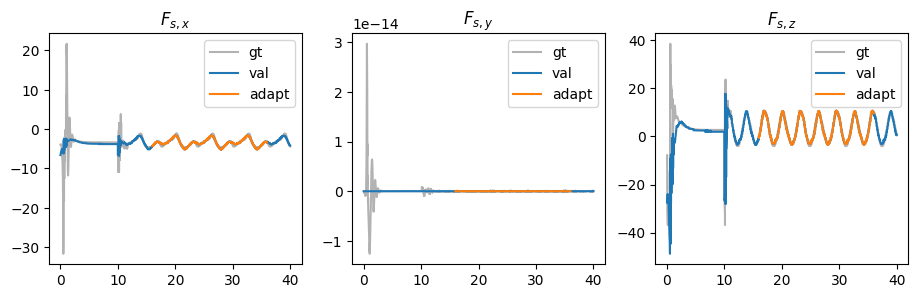

------------------------------
50wind:
a = [[-1.12597762e+00 -8.84795369e-18 -5.29445828e+00]
 [-1.37955594e+00 -7.60870181e-19  8.11041797e+00]
 [-3.10866143e+00  1.09442191e-18 -9.03138279e+00]
 [-1.07513429e+00  9.40037087e-19  3.84139055e+00]]
|a| = 14.287162568740339


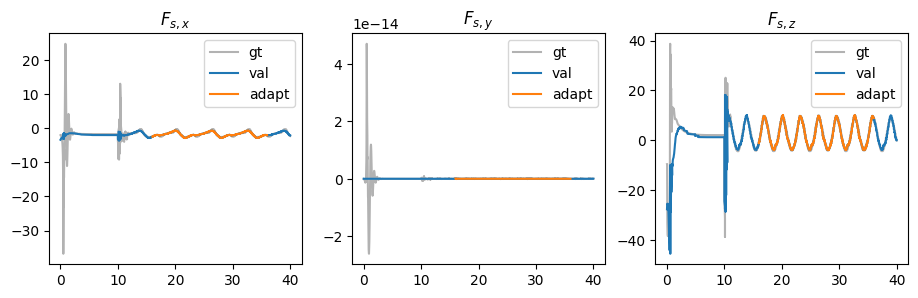

------------------------------
30wind:
a = [[-4.01165017e-01 -6.63652208e-18 -5.20192744e+00]
 [-1.07126474e+00  1.27330376e-18  8.12126912e+00]
 [-1.85902541e+00 -2.26127255e-18 -9.15009812e+00]
 [-2.14603042e-01  1.00024291e-18  3.83881152e+00]]
|a| = 14.010224914322148


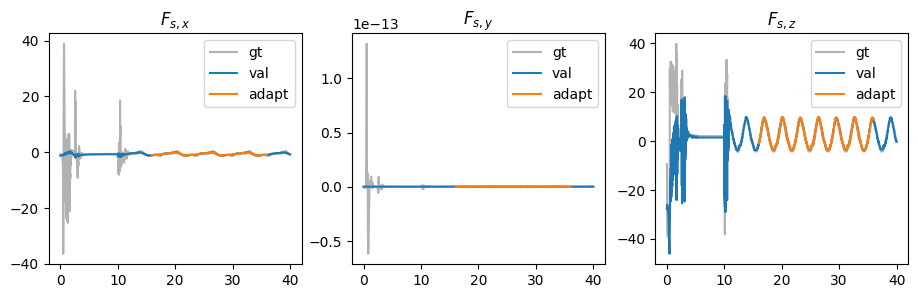

------------------------------
10wind:
a = [[-7.19528550e-02 -3.83144100e-17 -5.07853567e+00]
 [-5.60151071e-01  2.08501533e-17  8.09100749e+00]
 [-7.90022928e-01 -1.49193941e-18 -9.10768275e+00]
 [ 9.90803311e-02  2.36609728e-18  3.87252098e+00]]
|a| = 13.78967476158671


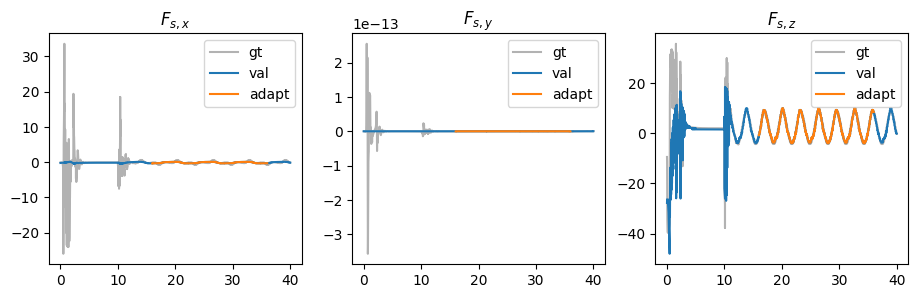

------------------------------
nowind:
a = [[-1.47624782e-01 -1.88569102e-18 -5.05679764e+00]
 [-3.57644735e-01 -6.20952353e-19  8.09319692e+00]
 [-4.83473128e-01 -1.20288562e-18 -9.07979345e+00]
 [ 1.26320651e-01  7.71575103e-19  3.87967453e+00]]
|a| = 13.746452931965916


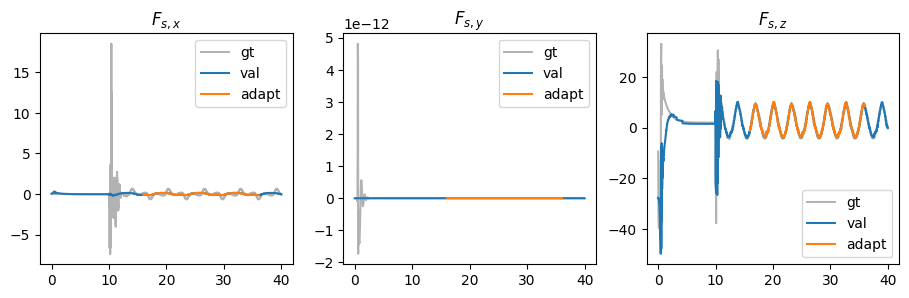

In [16]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=800, idx_adapt_end=1800, idx_val_start=0, idx_val_end=2000, c=Data[i].C, options=options)

In [17]:
for data in TestData:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** : 70wind ****
Before learning: MSE is  21.19
Mean predictor: MSE is  14.53
After learning phi(x): MSE is  5.33

**** : 50wind ****
Before learning: MSE is  17.30
Mean predictor: MSE is  14.50
After learning phi(x): MSE is  5.60

**** : 30wind ****
Before learning: MSE is  20.82
Mean predictor: MSE is  18.86
After learning phi(x): MSE is  10.43

**** : 10wind ****
Before learning: MSE is  19.33
Mean predictor: MSE is  17.65
After learning phi(x): MSE is  9.49

**** : nowind ****
Before learning: MSE is  14.50
Mean predictor: MSE is  13.12
After learning phi(x): MSE is  4.57

